In [132]:
%pip install nltk
%pip install scikit-learn
%pip install spacy
%pip install keras
%pip install seaborn
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


[nltk_data] Downloading package punkt to /home/ucloud/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ucloud/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [133]:
import pandas as pd
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from nltk import pos_tag
import matplotlib.pyplot as plt
import numpy as np
import spacy

In [174]:
# Load the CSV file with only German and Spanish native speakers (frog&chaplin task) into a pandas DataFrame
df = pd.read_csv("data1.csv", sep= "\t")

In [175]:
# we can see here that our data is not so balanced, there are many more texts from Spanish speakers
native_lang = "L1"

# Count unique values in the specified column
unique_value_counts = df[native_lang].value_counts()

# Print the counts of unique values
print(unique_value_counts)

L1
Spanish    1137
German      449
Name: count, dtype: int64


In [176]:
#So we are going to balance it
# Calculate the minimum count for each unique combination of values in the specified columns
min_counts =df.groupby(native_lang).size().min()

# Perform stratified sampling
df1 = pd.concat([group.sample(min_counts) for name, group in df.groupby(native_lang)])

In [177]:
# Count unique values in the specified column
unique_value_counts = df1[native_lang].value_counts()

# Print the counts of unique values
print(unique_value_counts)

# Now, 'L1' contains an equal number of rows for each unique combination of values in the specified column

L1
German     449
Spanish    449
Name: count, dtype: int64


In [178]:
#function to tag our text (POS tag=part of speech tag)
def pos_tagging(text):
    # Tokenize the text into words
    words = nltk.word_tokenize(text)
    # Perform POS tagging on the words
    pos_tags = nltk.pos_tag(words)
    # Join the POS tags 
    tagged_text = ' '.join([f'{pos}' for word, pos in pos_tags])
    return tagged_text

In [180]:
# we iterate over each row and apply the pos_tagging function
for index, row in df1.iterrows():
    df1.at[index, "Text"] = pos_tagging(row["Text"])

In [181]:
x_new = df1["Text"]
y_new = df1["L1"]

In [182]:
# Split the data into training (80%) and test sets (20%)
x_train, x_test, y_train, y_test = train_test_split(x_new, y_new, test_size=0.2, random_state=48)

In [183]:
# Use TfidfVectorizer to convert text data to numerical features
vectorizer = TfidfVectorizer(ngram_range=(2, 4))  # Use n-grams from size 2 to 4
x_train_features = vectorizer.fit_transform(x_train)
x_test_features= vectorizer.transform(x_test)

In [184]:
#SVC Linear (Linear Support Vector Classifier) was the ML model that got the best performance rate when we ran Lazypredict on our data
# Create and train the SVM classifier (SVM stands for Support Vector Machine, which is a supervised learning algorithm used for classification tasks).
classifier = SVC(kernel='linear')
classifier.fit(x_train_features, y_train)

SVC(kernel='linear')

In [185]:
# Predict the labels of the test set
y_pred = classifier.predict(x_test_features)

In [186]:
#let's see the predictions
print(y_pred[:10])

['Spanish' 'Spanish' 'German' 'German' 'Spanish' 'Spanish' 'Spanish'
 'Spanish' 'Spanish' 'German']


In [187]:
from sklearn.metrics import confusion_matrix, classification_report

# y_true is the ground truth labels and y_pred is the model's predictions
y_true =  y_test


# Evaluation of our model's performance with confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

# Calculate and print the classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred))


Confusion Matrix:
[[80  5]
 [15 80]]

Classification Report:
              precision    recall  f1-score   support

      German       0.84      0.94      0.89        85
     Spanish       0.94      0.84      0.89        95

    accuracy                           0.89       180
   macro avg       0.89      0.89      0.89       180
weighted avg       0.89      0.89      0.89       180



In [188]:
#Now we want to analyze what these results mean, how can we translate it to actual linguistic research
# Retrieve feature names
feature_names = vectorizer.get_feature_names_out()

In [189]:
# Get the coefficients from the classifier
# Convert the csr_matrix to a dense array
coefficients_dense = classifier.coef_.toarray().flatten()

# Create a DataFrame with feature names and their coefficients
# Convert the coefficients array to a DataFrame
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients_dense
})

# Sort the DataFrame by absolute value of the coefficients in descending order
coef_df_sorted = coef_df.reindex(coef_df['Coefficient'].abs().sort_values(ascending=False).index)

# Print the first few rows of the sorted DataFrame for verification
print(coef_df_sorted.head())

      Feature  Coefficient
4194    in dt    -1.748180
18915  rb vbz    -1.385663
6442    jj nn    -1.251518
1004    cc rb    -1.203215
271     cc jj    -1.184571


In [190]:
#We want to know which is the negative/positive class in our model, so we understand the feature coefficient later
# Print the class labels
print("Class labels:", classifier.classes_)

Class labels: ['German' 'Spanish']


In [191]:
#the previous means that German is the negative class (0) and Spanish the positive class (1)
#The larger the absolute value of the coefficient, the more significant the feature is in the classification process

In [192]:
#Let's plot our data to have a better idea of our results
# we are interested in plotting the top features
top_n = 20 

# Extract the top N features and their coefficients
top_features = coef_df_sorted.head(top_n)

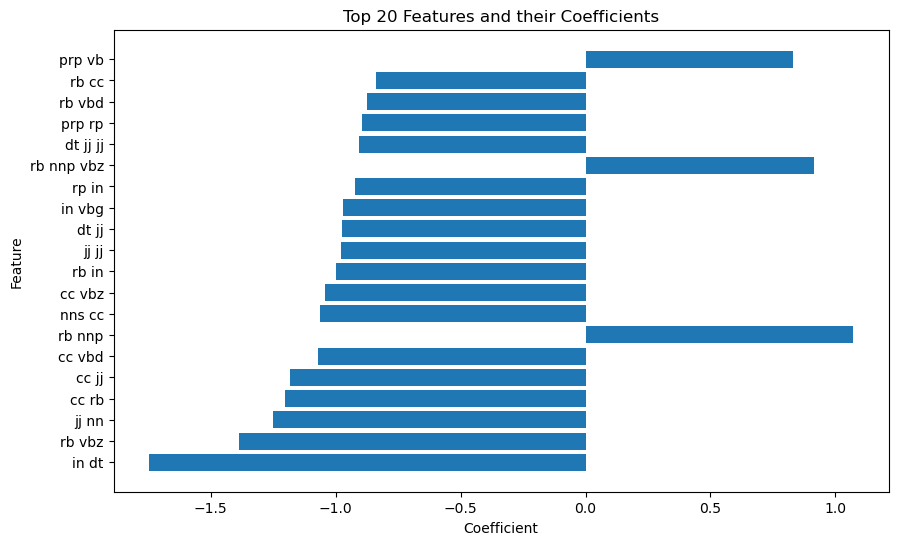

In [193]:
# We'll create a bar plot
plt.figure(figsize=(10, 6))  # Set figure size for better readability
plt.barh(top_features['Feature'], top_features['Coefficient'])

plt.xlabel('Coefficient')
plt.ylabel('Feature')
plt.title(f'Top {top_n} Features and their Coefficients')

plt.show()

In [194]:
#results show that the most relevant features for the classifier are found in German native speakers

In [195]:
#code to get POS tags definitions
nltk.download('tagsets')

# Load the Penn Treebank tagset
tagset = nltk.data.load('help/tagsets/upenn_tagset.pickle')

# Print the POS tag meanings
for tag, description in tagset.items():
    print(f"{tag}: {description[0]}")

LS: list item marker
TO: "to" as preposition or infinitive marker
VBN: verb, past participle
'': closing quotation mark
WP: WH-pronoun
UH: interjection
VBG: verb, present participle or gerund
JJ: adjective or numeral, ordinal
VBZ: verb, present tense, 3rd person singular
--: dash
VBP: verb, present tense, not 3rd person singular
NN: noun, common, singular or mass
DT: determiner
PRP: pronoun, personal
:: colon or ellipsis
WP$: WH-pronoun, possessive
NNPS: noun, proper, plural
PRP$: pronoun, possessive
WDT: WH-determiner
(: opening parenthesis
): closing parenthesis
.: sentence terminator
,: comma
``: opening quotation mark
$: dollar
RB: adverb
RBR: adverb, comparative
RBS: adverb, superlative
VBD: verb, past tense
IN: preposition or conjunction, subordinating
FW: foreign word
RP: particle
JJR: adjective, comparative
JJS: adjective, superlative
PDT: pre-determiner
MD: modal auxiliary
VB: verb, base form
WRB: Wh-adverb
NNP: noun, proper, singular
EX: existential there
NNS: noun, common, p

[nltk_data] Downloading package tagsets to /home/ucloud/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!


**SECOND PART**  
Now that we got a good performance using the GERMAN/SPANISH corpus, let's test our model with a "control" dataset with ENGLISH native speakers.  


**FOCUSING ON WORD ORDER OF 3 CLASSES (ENGLISH-GERMAN-SPANISH)**

In [196]:
# Load the CSV file with only English native speakers (frog&chaplin task) into a pandas DataFrame
df_control = pd.read_csv("natives.csv", sep= "\t")

In [197]:
#we select the columns we are interested in
df2=df_control[['L1', 'Text']]

In [198]:
#we select the columns from the first corpus (German-Spanish native speakers) 
df3=df[['L1', 'Text']]

In [199]:
#We merge both dataframes
df4=pd.concat([df3, df2], sort=False)

In [200]:
df4

,L1,Text
0,German,One day Tommy found a frog in a forest and bro...
1,German,One day Tommy found a frog in the Forest. He b...
2,German,One day a little boy called John uh with his d...
3,German,"One day, there was a boy called John who wante..."
4,German,One day a boy was sitting in his room / uh he ...
...,...,...
133,English,There is a man with a stick walking along a na...
134,English,Chaplin is walking though a building site and ...
135,English,A man (the character Charlie Chaplin) is walki...
136,English,One day a little boy and his dog were admiring...


In [201]:
# Specify the column you want to count unique values from
lang = "L1"

# Count unique values in the specified column
unique_value_counts1 = df4[lang].value_counts()

# Print the counts of unique values
print(unique_value_counts1)

#We can see here that our dataframe is not really balanced, which could make our results biased(?

L1
Spanish    1137
German      449
English     138
Name: count, dtype: int64


In [202]:
# Calculate the minimum count for each unique combination of values in the specified columns
min_count =df4.groupby(lang).size().min()

# Perform stratified sampling
df4 = pd.concat([group.sample(min_count) for name, group in df4.groupby(lang)])

# Now, 'balanced_data' should contain an equal number of rows for each unique combination of values in the specified columns

In [203]:
# let's count unique values again and see if it worked
# Count unique values in the specified column
unique_value_count = df4[lang].value_counts()

# Print the counts of unique values
print(unique_value_count)

L1
English    138
German     138
Spanish    138
Name: count, dtype: int64


In [204]:
#we convert the column text into strings
df4["Text"] = df4["Text"].astype(str)

In [205]:
df4

,L1,Text
81,English,Chaplain is walking past a window when some br...
129,English,Charlie Chaplin is walking through a building ...
116,English,Charlie Chaplin was walking down an alley. Peo...
54,English,"One day, Joe caught a frog. He put it in a jar..."
39,English,During this video there was a man just walking...
...,...,...
860,Spanish,hello / my name is / ryan 'n' / 'n' this video...
712,Spanish,"One day, a boy had a frog, The frog scape for ..."
757,Spanish,"One day, a children with his dog had a frog i..."
1020,Spanish,One day a boy called Tom caught a frog and put...


In [206]:
print(df4["Text"])
print(df4["Text"].dtype)

81      Chaplain is walking past a window when some br...
129     Charlie Chaplin is walking through a building ...
116     Charlie Chaplin was walking down an alley. Peo...
54      One day, Joe caught a frog. He put it in a jar...
39      During this video there was a man just walking...
                              ...                        
860     hello / my name is / ryan 'n' / 'n' this video...
712     One day, a boy had a frog, The frog scape for ...
757     One day,  a children with his dog had a frog i...
1020    One day a boy called Tom caught a frog and put...
1305    The main character is walking in the street. A...
Name: Text, Length: 414, dtype: object
object


In [207]:
# we iterate over each row and apply the pos_tagging function
for index, row in df4.iterrows():
    df4.at[index, "Text"] = pos_tagging(row["Text"])

In [208]:
print(df4["Text"])

81      NNP VBZ VBG IN DT NN WRB DT NNS VBP IN NN IN P...
129     IN PRP MD VB NNP NNP VBG IN DT NNS VBP JJ NN E...
116     NNP NNP VBD VBG RP DT NN . NNS IN DT NNS IN VB...
54      CD NN , NNP VBD DT NN . PRP VBD PRP IN DT NN I...
39      IN DT NN EX VBD DT NN RB VBG RB CC VBG PRP$ JJ...
                              ...                        
860     NN VB PRP$ NN VBZ JJ JJ POS POS JJ NNS POS DT ...
712     CD NN , DT NN VBD DT NN , DT NN NN IN DT NN . ...
757     CD NN , DT NNS IN PRP$ NN VBD DT NN IN DT NN ....
1020    CD NN DT NN VBN NNP VBD DT NN CC VB IN DT NN ,...
1305    DT JJ NN VBZ VBG IN DT NN . NNP NN WRB NNS VBP...
Name: Text, Length: 414, dtype: object


In [209]:
# Extract text data and labels
x= df4["Text"]
y= df4["L1"]

In [210]:
# Split the data into training and test sets
x_train1, x_test1, y_train1, y_test1 = train_test_split(x, y, test_size=0.2, random_state=48)

In [211]:
# Use TfidfVectorizer to convert text data to numerical features
vectorizer = TfidfVectorizer(ngram_range=(2, 4))  # we use n-grams from size 2 to 4
x_train_features1 = vectorizer.fit_transform(x_train1)
x_test_features1= vectorizer.transform(x_test1)

In [212]:
#SVC Linear (Linear Support Vector Classifier) was the ML model that got the best performance rate when we ran Lazypredict on our data
# Create and train the SVM classifier (SVM stands for Support Vector Machine, which is a supervised learning algorithm used for classification tasks).
classifier= SVC(kernel='linear')
classifier.fit(x_train_features1, y_train1)

SVC(kernel='linear')

In [213]:
# Predict the labels of the test set
y_pred1 = classifier.predict(x_test_features1)

In [214]:
from sklearn.metrics import confusion_matrix, classification_report

y_true1 =  y_test1

# Calculate confusion matrix
cm_new = confusion_matrix(y_true1, y_pred1)
print("Confusion Matrix:")
print(cm_new)

# Calculate and print the classification report
print("\nClassification Report:")
print(classification_report(y_true1, y_pred1))

Confusion Matrix:
[[ 6 19  0]
 [ 9 17  1]
 [ 6  5 20]]

Classification Report:
              precision    recall  f1-score   support

     English       0.29      0.24      0.26        25
      German       0.41      0.63      0.50        27
     Spanish       0.95      0.65      0.77        31

    accuracy                           0.52        83
   macro avg       0.55      0.50      0.51        83
weighted avg       0.58      0.52      0.53        83



**We got a lower value but we still consider that the model has potential. Further research could enhance its use in studying language transfer and serve as an effective tool for improving language teaching methods.**